<a href="https://colab.research.google.com/github/mart-anthony-stark/Machine-Learning-and-Deep-Learning/blob/main/Train_Object_Detection_model_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TRAINING AN OBJECT DETECTION MODEL FOR CUSTOM DATASET  (TensorFlow 2.x)**

**This notebook is part of this [blog post](https://techzizou.com/training-an-ssd-model-for-a-custom-object-using-tensorflow-2-x/)**



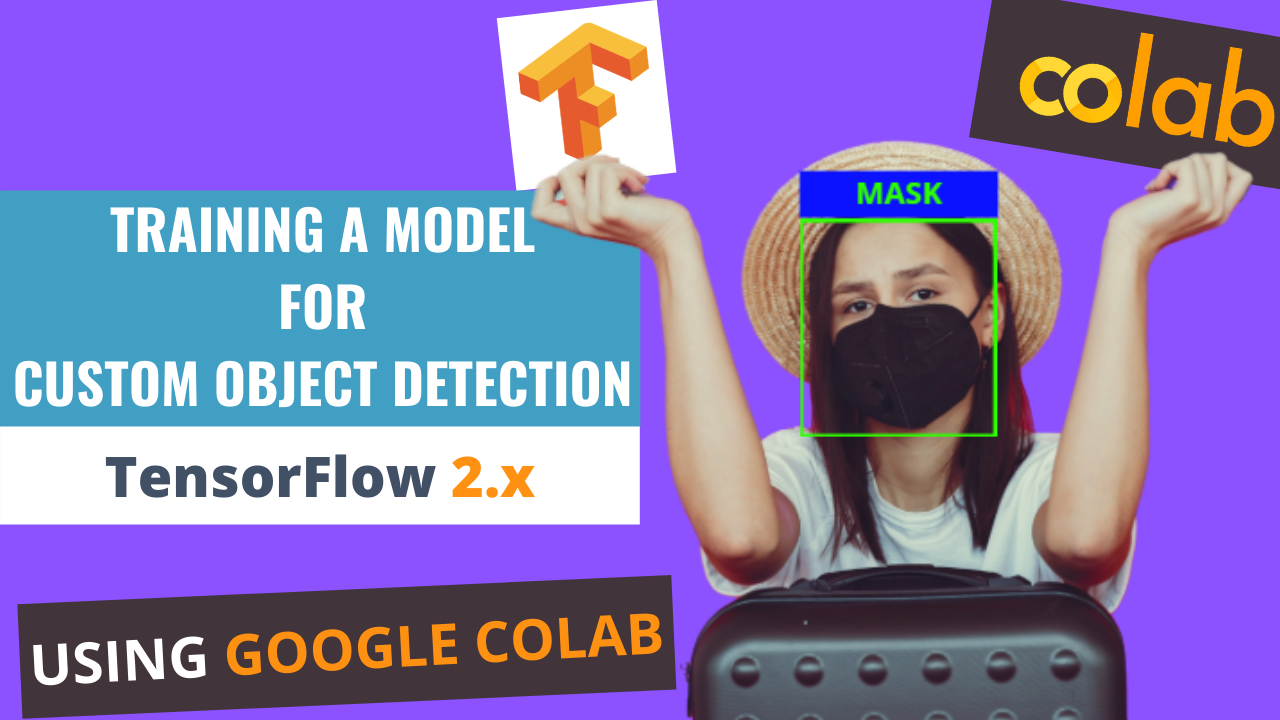



# **In this tutorial, we will be training a custom detector for mask detection using an SSD model**



## **ROADMAP**


* Collect the dataset of images and label them to get their xml files.

* Install the TensorFlow Object Detection API.

* Generate the TFRecord files required for training. (need generate_tfrecord.py script and csv files for this)

* Edit the model pipeline config file and download the pre-trained model checkpoint.

* Train and evaluate the model.





# **1) Import Libraries**

In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf
print(tf.__version__)


# **2) Create *`customTF2`*, *`training`* and *`data`* folders in your google drive**
Create a folder named ***customTF2*** in your google drive.

Create another folder named ***training*** inside the ***customTF2*** folder
(***training*** folder is where the checkpoints will be saved during training)

Create another folder named ***data*** inside the ***customTF2*** folder.


# **3) Create and upload your image files and xml files.**
 Create a folder named ***images*** for your custom dataset images and create another folder named ***annotations*** for its corresponding xml files.
 
 Next, create their zip files and upload them to the ***customTF2*** folder in your drive.

 
 (Make sure all the image files have extension as ".jpg" only.
 Other formats like ".png" , ".jpeg" or even ".JPG" will give errors since the generate_tfrecord and xml_to_csv scripts here have only ".jpg" in them)








## Collect Images Dataset and label them to get their PASCAL_VOC XML annotations
For Datasets, you can check out my Dataset Sources at the bottom of this article in the credits section. You can use any software for labeling like the labelImg tool.

Read this [article](https://techzizou.com/dataset-labeling-annotation-tutorial-for-beginners/) to know more about collecting datasets and labeling process.

# **4) Upload the *`generate_tfrecord.py`* file to the *`customTF2`* folder on your drive.**


You can find the generate_tfrecord.py file [here](https://github.com/techzizou/Train-Object-Detection-Model-TF-2.x)

#**5) Mount drive and link your folder**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

# **6) Clone the tensorflow models git repository & Install TensorFlow Object Detection API**





In [ ]:
# clone the tensorflow models on the colab cloud vm
!git clone --q https://github.com/tensorflow/models.git

#navigate to /models/research folder to compile protos
%cd models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .


# **7) Test the model builder**


In [ ]:
# testing the model builder
!python object_detection/builders/model_builder_tf2_test.py

# **8) Navigate to /mydrive/customTF2/data/ and Unzip the *images.zip* and *annotations.zip* files into the *data* folder**



In [ ]:
%cd /mydrive/customTF2/data/

# unzip the datasets and their contents so that they are now in /mydrive/customTF2/data/ folder
!unzip /mydrive/customTF2/images.zip -d .
!unzip /mydrive/customTF2/annotations.zip -d .

# **9) Create test_labels & train_labels**
Current working directory is /mydrive/customTF2/data/

Divide annotations into test_labels(20%) and train_labels(80%).

In [ ]:
#creating two dir for training and testing
!mkdir test_labels train_labels

# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 274/1370 labels (20% of the labels) to the testing dir: `test_labels`
!ls annotations/* | sort -R | head -274 | xargs -I{} mv {} test_labels/


# Moves the rest of the labels ( 1096 labels ) to the training dir: `train_labels`
!ls annotations/* | xargs -I{} mv {} train_labels/

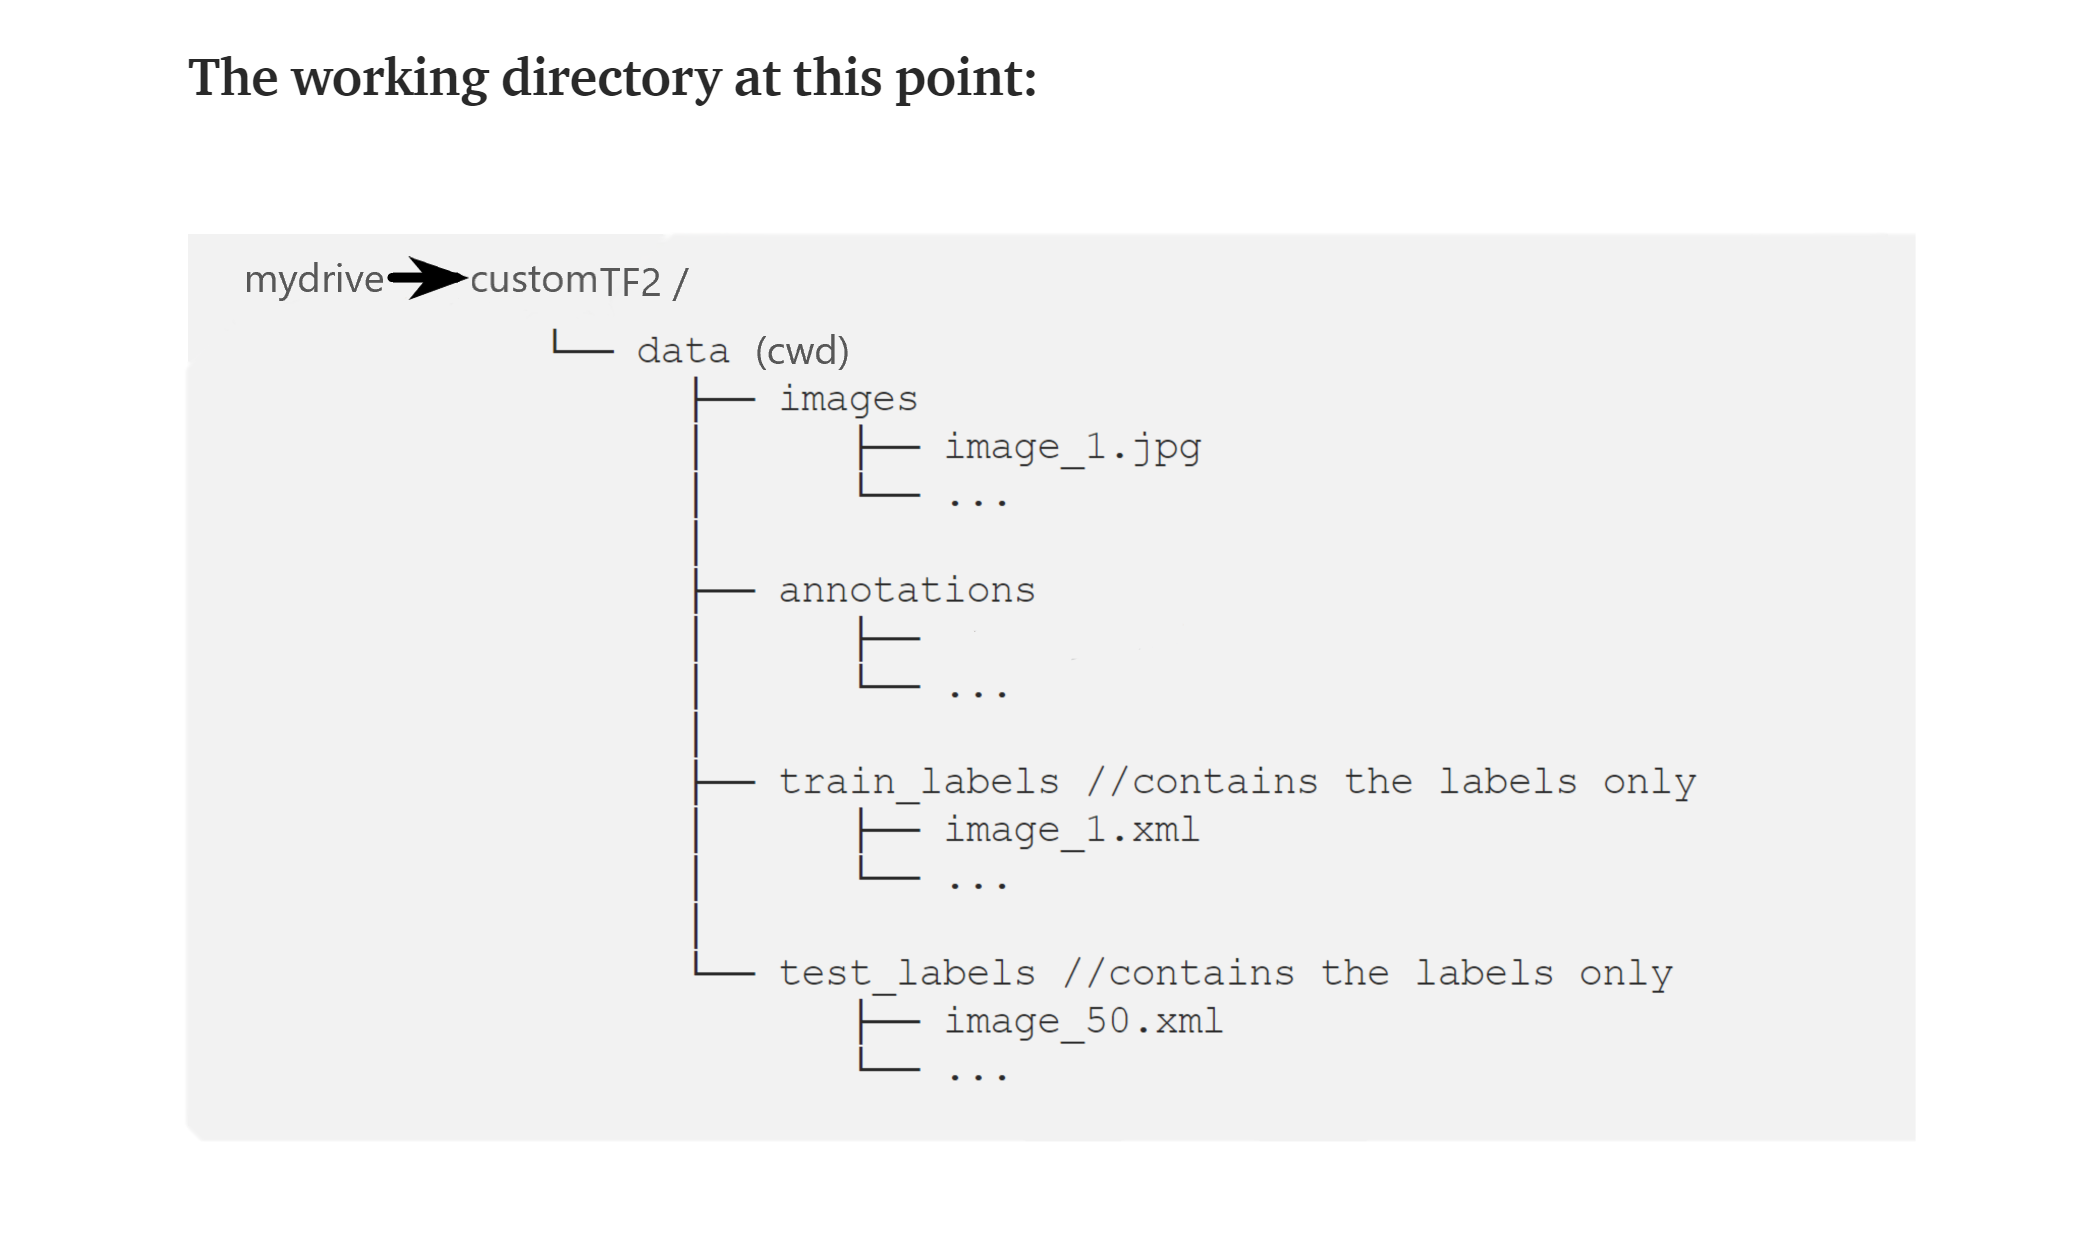

# **10) Create the CSV files and the "label_map.pbtxt" file**

Current working directory is /mydrive/customTF2/data/

Run xml_to_csv script below to create ***test_labels.csv*** and ***train_labels.csv***

This also creates the ***label_map.pbtxt*** file using the classes mentioned in the xml files. 

In [ ]:
#adjusted from: https://github.com/datitran/raccoon_dataset
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text  ,   
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print('Successfully created label_map.pbtxt ')   

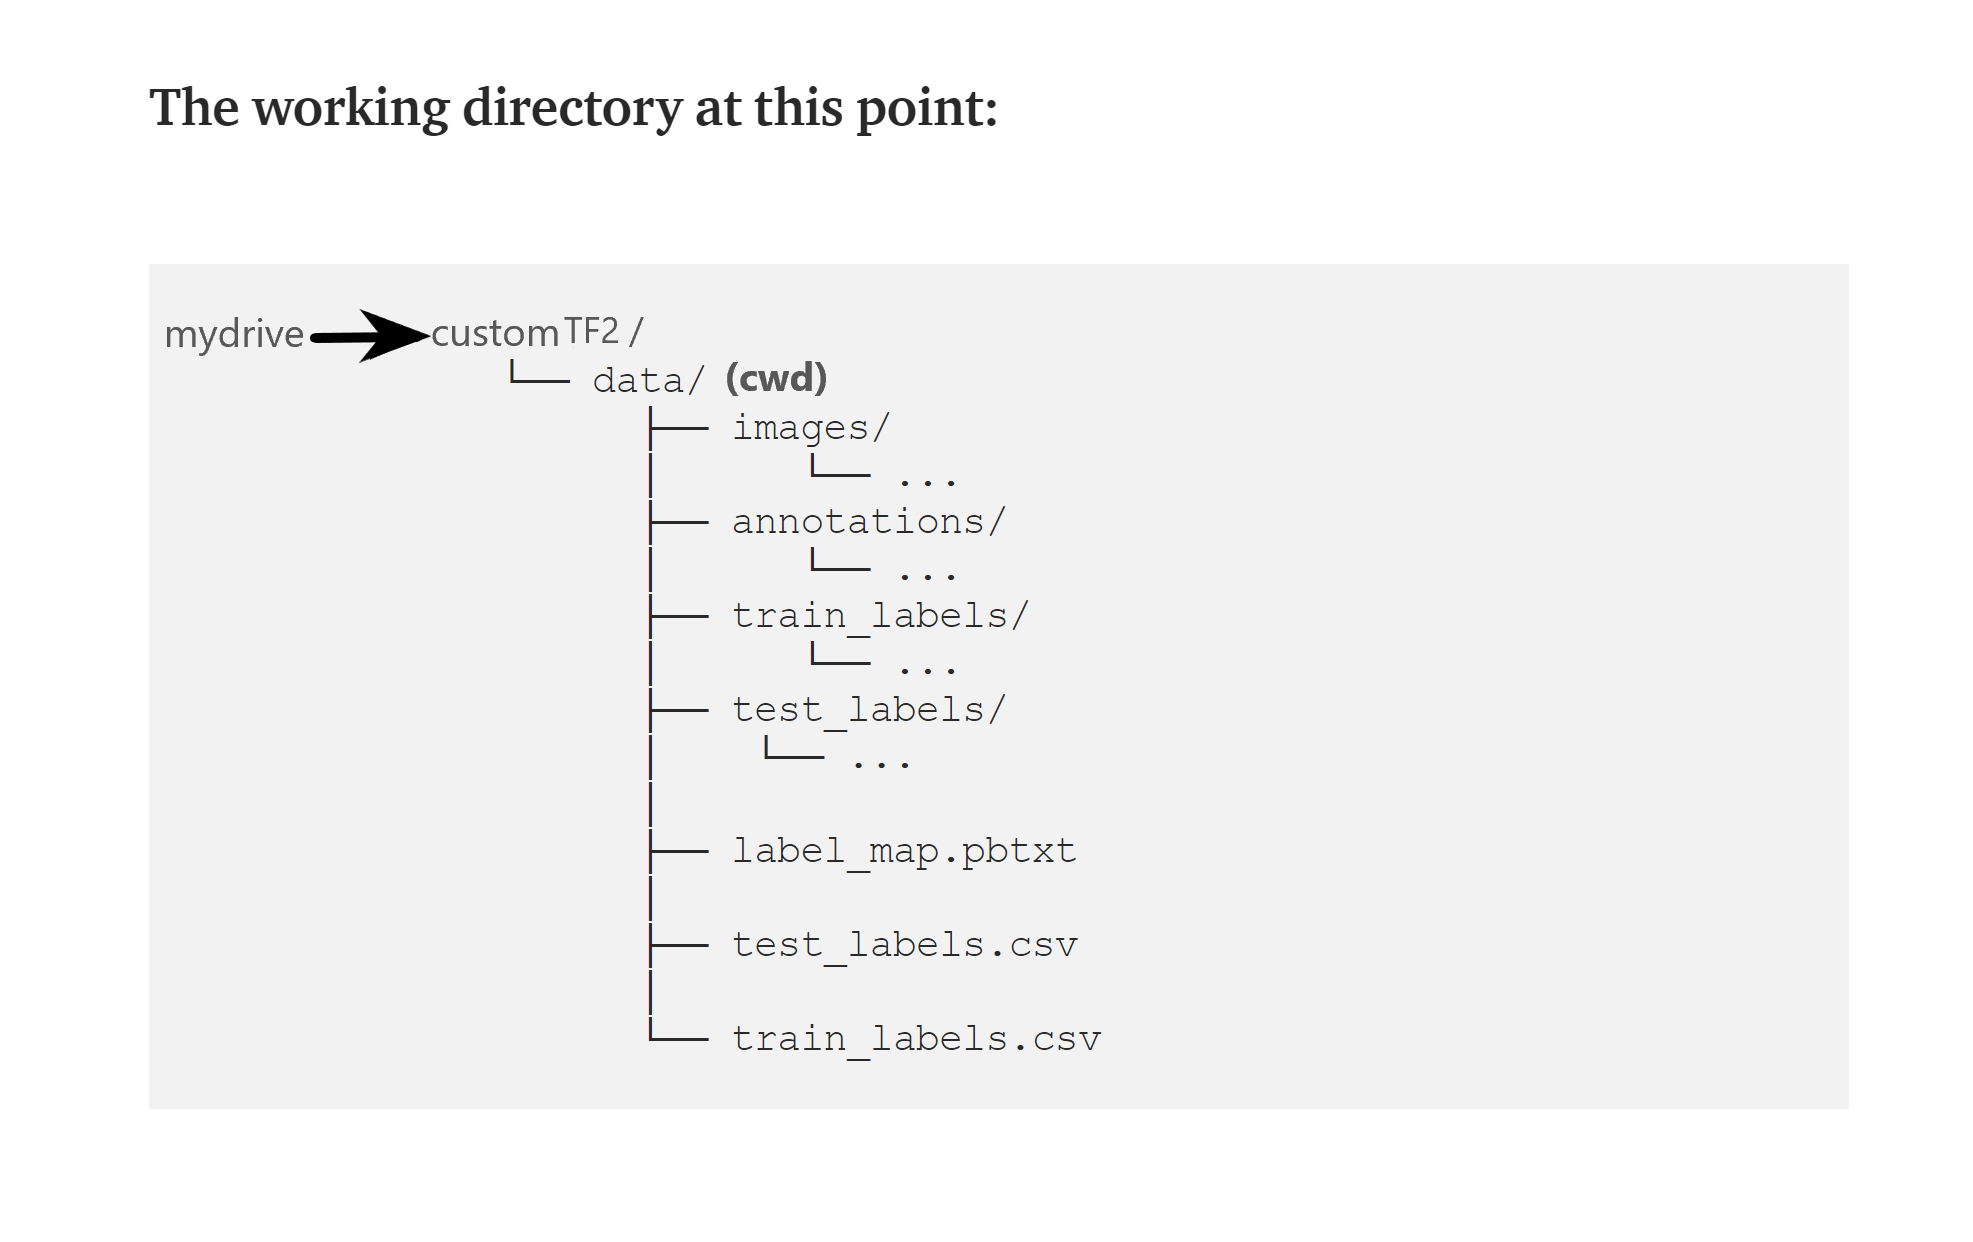

# **11) Create train.record & test.record files**

Current working directory is /mydrive/customTF2/data/

Run the *generate_tfrecord.py* script to create *train.record* and *test.record* files



In [ ]:
#Usage:  
#!python generate_tfrecord.py output.csv output_pb.txt /path/to/images output.tfrecords

#For train.record
!python /mydrive/customTF2/generate_tfrecord.py train_labels.csv  label_map.pbtxt images/ train.record

#For test.record
!python /mydrive/customTF2/generate_tfrecord.py test_labels.csv  label_map.pbtxt images/ test.record


# **12) Download pre-trained model checkpoint** 

Current working directory is /mydrive/customTF2/data/

Download **ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz** into the ***data*** folder & unzip it.

A list of detection checkpoints for tensorflow 2.x can be found [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).



In [ ]:
#Download the pre-trained model ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz into the data folder & unzip it.

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# **13) Get the model pipeline config file, make changes to it and put it inside the *data* folder**

Current working directory is /mydrive/customTF2/data/

Download **ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config** from ***/content/models/research/object_detection/configs/tf2***. Make the required changes to it and upload it to the ***/mydrive/custom/data*** folder.

**OR**

Edit the config file from ***/content/models/research/object_detection/configs/tf2*** in colab and copy the edited config file to the ***/mydrive/customTF2/data*** folder.

You can also find the pipeline config file inside the model checkpoint folder we just downloaded in the previous step.

**You need to make the following changes:**
*   change ***num_classes*** to number of your classes.
*   change ***test.record*** path, ***train.record*** path & ***labelmap*** path to the paths where you have created these files (paths should be relative to your current working directory while training).
* change ***fine_tune_checkpoint*** to the path of the directory where the downloaded checkpoint from step 12 is. 
* change ***fine_tune_checkpoint_type*** with value **classification** or **detection** depending on the type..
* change ***batch_size*** to any multiple of 8 depending upon the capability of your GPU.
(eg:- 24,128,...,512).Mine is set to 64. 
* change ***num_steps*** to number of steps you want the detector to train. 







In [ ]:
#copy the edited config file from the configs/tf2 directory to the data/ folder in your drive

!cp /content/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config /mydrive/customTF2/data

# **14) Load Tensorboard**

In [ ]:
#load tensorboard

%load_ext tensorboard
%tensorboard --logdir '/content/gdrive/MyDrive/customTF2/training'

# **15) Train the model** 






## Navigate to the ***object_detection*** folder in colab vm


In [ ]:
%cd /content/models/research/object_detection

## 15 (a) Training using model_main_tf2.py

Here **{PIPELINE_CONFIG_PATH}** points to the pipeline config and **{MODEL_DIR}** points to the directory in which training checkpoints and events will be written.

For best results, you should stop the training when the loss is less than 0.1 if possible, else train the model until the loss does not show any significant change for a while. The ideal loss should be below 0.05 (Try to get the loss as low as possible without overfitting the model. Don’t go too high on training steps to try and lower the loss if the model has already converged viz. if it does not reduce loss significantly any further and takes a while to go down. )

In [ ]:
# Run the command below from the content/models/research/object_detection directory
"""
PIPELINE_CONFIG_PATH=path/to/pipeline.config
MODEL_DIR=path to training checkpoints directory
NUM_TRAIN_STEPS=50000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1

python model_main_tf2.py -- \
  --model_dir=$MODEL_DIR --num_train_steps=$NUM_TRAIN_STEPS \
  --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
  --pipeline_config_path=$PIPELINE_CONFIG_PATH \
  --alsologtostderr
"""

!python model_main_tf2.py --pipeline_config_path=/mydrive/customTF2/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=/mydrive/customTF2/training --alsologtostderr

### <u>**TROUBLESHOOTING:**</u> 
If you get an error for _registerMatType cv2 above, this might be because of OpenCV version mismatches in Colab. Run `!pip list|grep opencv` to see the versions of OpenCV packages installed i.e. `opencv-python`, `opencv-contrib-python` & `opencv-python-headless`. The versions will be different which is causing this error. This error will go away when colab updates it supported versions. For now, you can fix this by simply uninstalling and installing OpenCV packages. 

**Check versions:**

!pip list|grep opencv


**Use the following 2 commands if only the opencv-python-headless is of different version**:

!pip uninstall opencv-python-headless --y

!pip install opencv-python-headless==4.1.2.30


**Or use the following commands if other opencv packages are of different versions. Uninstall and install all with the same version**:

!pip uninstall opencv-python --y

!pip uninstall opencv-contrib-python --y 

!pip uninstall opencv-python-headless --y


!pip install opencv-python==4.5.4.60

!pip install opencv-contrib-python==4.5.4.60

!pip install opencv-python-headless==4.5.4.60


## 15 (b) Evaluation using model_main_tf2.py (Optional)

You can run this in parallel by opening another colab notebook and running this command simultaneously along with the training command above (don't forget to mount drive, clone the TF git repo and install the TF2 object detection API there as well). This will give you validation loss, mAP, etc so you have a better idea of how your model is performing.

Here **{CHECKPOINT_DIR}** points to the directory with checkpoints produced by the training job. Evaluation events are written to **{MODEL_DIR/eval}**. 

In [ ]:
# Run the command below from the content/models/research/object_detection directory
"""
PIPELINE_CONFIG_PATH=path/to/pipeline.config
MODEL_DIR=path to training checkpoints directory
CHECKPOINT_DIR=${MODEL_DIR}
NUM_TRAIN_STEPS=50000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1

python model_main_tf2.py -- \
  --model_dir=$MODEL_DIR --num_train_steps=$NUM_TRAIN_STEPS \
  --checkpoint_dir=${CHECKPOINT_DIR} \
  --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
  --pipeline_config_path=$PIPELINE_CONFIG_PATH \
  --alsologtostderr
"""

!python model_main_tf2.py --pipeline_config_path=/mydrive/customTF2/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=/mydrive/customTF2/training/ --checkpoint_dir=/mydrive/customTF2/training/ --alsologtostderr

## RETRAINING THE MODEL ( in case you get disconnected )


If you get disconnected or lose your session on colab vm, you can start your training where you left off as the checkpoint is saved on your drive inside the ***training*** folder. To restart the training simply run **steps 1, 5, 6, 7, 14, and 15**

Note that since we have all the files required for training like the record files,our edited pipeline config file,the label_map file and the model checkpoint folder, therefore we do not need to create these again. 

**The model_main_tf2.py script saves the checkpoint every 1000 steps.** The training automatically restarts from the last saved checkpoint itself.

However, if you see that it doesn't restart training from the last checkpoint you can make 1 change in the pipeline config file. Change **fine_tune_checkpoint** to where your latest trained checkpoints have been written and have it point to the latest checkpoint as shown below:


``` 
fine_tune_checkpoint: "/mydrive/customTF2/training/ckpt-X" (where ckpt-X is the latest checkpoint)

```


# **16) Test your trained model**

## Export inference graph

Current working directory is /content/models/research/object_detection

In [ ]:
##Export inference graph
!python exporter_main_v2.py --trained_checkpoint_dir=/mydrive/customTF2/training --pipeline_config_path=/content/gdrive/MyDrive/customTF2/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --output_directory /mydrive/customTF2/data/inference_graph

## Test your trained Object Detection model on images

Current working directory is /content/models/research/object_detection

In [ ]:
# Different font-type for labels text.(This step is optional)
!wget https://freefontsdownload.net/download/160187/arial.zip
!unzip arial.zip -d .

%cd utils/
!sed -i "s/font = ImageFont.truetype('arial.ttf', 24)/font = ImageFont.truetype('arial.ttf', 50)/" visualization_utils.py
%cd ..

In [ ]:
#Loading the saved_model
import tensorflow as tf
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

IMAGE_SIZE = (12, 8) # Output display size as you want
import matplotlib.pyplot as plt
PATH_TO_SAVED_MODEL="/mydrive/customTF2/data/inference_graph/saved_model"
print('Loading model...', end='')

# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

#Loading the label_map
category_index=label_map_util.create_category_index_from_labelmap("/mydrive/customTF2/data/label_map.pbtxt",use_display_name=True)
#category_index=label_map_util.create_category_index_from_labelmap([path_to_label_map],use_display_name=True)

def load_image_into_numpy_array(path):

    return np.array(Image.open(path))

image_path = "/mydrive/mask_test_images/image1.jpg"
#print('Running inference for {}... '.format(image_path), end='')

image_np = load_image_into_numpy_array(image_path)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.4, # Adjust this value to set the minimum probability boxes to be classified as True
      agnostic_mode=False)
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE, dpi=200)
plt.axis("off")
plt.imshow(image_np_with_detections)
plt.show()

## For testing on webcam capture or videos, use [this colab](https://colab.research.google.com/drive/17ej2V3gUg6PTl6PpyYjKWtTdFWLEEOGh?usp=sharing) notebook.

# **MY GITHUB** 


*   [Object Detection using Tensorflow 2.x](https://github.com/techzizou/Train-Object-Detection-Model-TF-2.x)

# **♕ TECHZIZOU ♕** 





# 🖖